# Notebook limpio, con el mínimo necesario para correr un modelo

## Import all the necessary libraries

In [207]:
%matplotlib inline
from collections import Counter
import datetime
import itertools
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import sys

my_stop_words = []

## Functions

##### Get training and testing data

In [208]:
def create_num_features(df):
    'A function to grab all the desired numerical features from the dataset'
    aux = df.copy()
    df['tweet_created'] = pd.to_datetime(df.tweet_created)
    aux['day_of_month'] = df.apply(lambda x: x.tweet_created.day, axis = 1)
    aux['day_of_week'] = df.tweet_created.dt.dayofweek
    aux['day_of_year'] = df.tweet_created.dt.dayofyear
    aux['text_length'] = df.apply(lambda x: len(x.text), axis = 1)
    return aux


In [209]:
def obtain_data_representation(df, test = None, show_modelwords = False, show_modelparams = False, emojis = False, num = False, counter = 'TFIDF', max_feat = 250, token = r'([A-Za-z]{3,}|no)', stop_w = my_stop_words, min_df = 0.01, max_df = 0.7):
    'A function to obtain a matrix with the data representation necessary to train a model. It has several params:'
    # 1 - df -> Df with the data to convert
    # 2 - test -> if test is none, all data is train. If not, the data provided will be used as test.
    # 3 - show_modelwords -> If true, show the words that are included in the BoW passed to the ML algorithm to be trained.
    # 4 - show_modelparams -> If true, show the parameters of the transformator used in the BoW (not really interesting, though)
    # 5 - emojis -> If true, return a sparse matrix with, not only the parsed text of the tweet, b7 ut also the emojis found in the column named "emojis"
    # 6 - numeric -> If False, perform only the transformation of the text of the tweet. If true, return a dictionary containing:
    #       --> {'train' : {'text' : {'x' : sparse_matrix, 'y': response_vect}, 'num' {'x': pandas_df, 'y': response_vect}},
    #             'test' : {'text' : {'x' : sparse_matrix, 'y': response_vect}, 'num' {'x': pandas_df, 'y': response_vect}}}
    # 7 - counter -> Specify the desired counter to perform the transformation of text into a vector of features. Possible values are:
    #                    - 'TFIDF'
    #                    - 'CVEC'
    # 8 - max_feat -> Optionally, we can include the maximum number of features to put in our BoW. Default = 250
    # 9 - token -> Token pattern to give to the BoW. Default = r'(\w{3,}|no)'
    # 10 - stop_w -> Vector of stop words to give to the BoW. Default = []
    # 11 - min_df -> Minimum required frequency for a word to be included. Default = 0.01
    # 12 - max_df -> Maximum allowed frequency that can have a word. If it has higher freq, it will be excluded. Default = 0.7
    
    # En teoria esta parte funciona para python 3, pero no lo hace para python 2
    # re_prep = re.compile(r'[^\u263a-\U0001f645]')
    # def prep_func(s):
    #     'A preprocessing function to return only the emojis, and remove the plain text'
    #     return re_prep.sub('', s)
    # La funcion de python 2 que funcion de python 2 que si que funciona esta mas abajo, para crear la columna emojis
    
    # If there is no test data, split the input
    if test is None:
        train, test = train_test_split(df, test_size=0.25)
        df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        train = df
    
    try:
        if counter.lower() == 'tfidf':
            bow = TfidfVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
        elif counter.lower() == 'cvec':
            bow = CountVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
        else:
            print('Error in the counter definition for the BoW. Please check the value provided to make sure it is within the possible options')
            return {}
    except Exception as e:
        print(e)
        return {}

    x_train_txt = bow.fit_transform(train['text'])
    x_test_txt = bow.transform(test['text'])
    
    if emojis:
        dvec = DictVectorizer()
        x_train_emojis = dvec.fit_transform(Counter(s.split(',')) for s in train['emojis'])
        x_test_emojis = dvec.transform(Counter(s.split()) for s in test['emojis'])
        
        x_train = hstack([x_train_txt, x_train_emojis], format = 'csr')
        x_test = hstack([x_test_txt, x_test_emojis], format = 'csr')   
    else:
        x_train = x_train_txt
        x_test = x_test_txt 
      
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the model are: ', bow.get_feature_names())
        if emojis:
            print('Emojis foung are: ', dvec.vocabulary_)

    if show_modelparams:
        print ('Parameters for the model are: ', bow.get_params())

    y_train = train['airline_sentiment'].values 
    
    # If we want to return numeric features as well, we have to create the numerical dataset:
    
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
    
    if num:
        x_train_num = df[['day_of_month','day_of_week', 'day_of_year', 'retweet_count', 'reply_count', 'text_length']].copy()
        return {
                'train': {'text' : {
                            'x': x_train,
                            'y': y_train
                            },
                          'num' : { 
                            'x': x_train_num,
                            'y': y_train
                          }
                },
                'test': { 'test' : { 
                            'x': x_test,
                            'y': y_test
                            },
                        'num' : { 
                            'x': x_test_num,
                            'y': y_test
                            }
                        }
               }

    return {
            'train': {
                    'x': x_train,
                    'y': y_train
            },
            'test': {
                'x': x_test,
                'y': y_test
            }
           }

In [210]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## Read and Preprocess data

In [211]:
# Read the data and see how it looks like. Treat it a little bit to keep what is interesting for us
df = pd.read_csv('./tweets_public_spanish.csv', encoding='utf-16', index_col='tweet_id', sep=',')
df.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,
942743012337123328,positive,False,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",NaN,Mon Dec 18 13:07:04 +0000 2017,NaN,Dublin
926857871916183553,positive,True,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",NaN,Sat Nov 04 17:05:11 +0000 2017,NaN,NaN
936979305720090626,neutral,True,0,0,@Iberia Me dirías por favor que costo tiene?,NaN,Sat Dec 02 15:24:09 +0000 2017,NaN,NaN
943983853802328064,negative,True,0,0,"@SupermanlopezN @Iberia @giroditalia Champion,...",NaN,Thu Dec 21 23:17:43 +0000 2017,NaN,Central Time (US & Canada)
938207464457211904,negative,True,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,NaN,Wed Dec 06 00:44:25 +0000 2017,NaN,Eastern Time (US & Canada)


Let's explore the data to see what can we do with it and what columns may be useful for us

In [212]:
# Check the amount of data that we have:
print('The size of the training dataset is: (%i, %i)' % df.shape)

# Check the number of null values in the dataset:
print('The number of NULL values per column name are: ')
print(df.isnull().sum())

# It is interesting to notice that exactly the amount of values that have the negativereason null is the same as the sum of the 
# neutral and positive sentiments! Can we use that info?
print ('The number of positive, negative and neutral valorations in the training dataset are: ')
print(df.airline_sentiment.value_counts())

The size of the training dataset is: (7867, 9)
The number of NULL values per column name are: 
airline_sentiment       0
is_reply                0
reply_count             0
retweet_count           0
text                    0
tweet_coord          7845
tweet_created           0
tweet_location       7428
user_timezone        2748
dtype: int64
The number of positive, negative and neutral valorations in the training dataset are: 
negative    3788
neutral     2555
positive    1524
Name: airline_sentiment, dtype: int64


At first sight and due to the great amount of null values in the columns ***'tweet_coord'*** and ***'tweet_location'*** it can be inferred that those columns won't be of much use for us. The ***'user_timezone'*** doesn't seem to be useful for the kind of problem we are considering and has a lot of null values as well, so it will be droped together with the previous two commented columns

In [213]:
df.drop(['tweet_coord', 'tweet_location', 'user_timezone'], axis = 1, inplace = True)

In [214]:
print (df.describe())

       reply_count  retweet_count
count       7867.0         7867.0
mean           0.0            0.0
std            0.0            0.0
min            0.0            0.0
25%            0.0            0.0
50%            0.0            0.0
75%            0.0            0.0
max            0.0            0.0


After using the describe() function to get some statistical data on the numerical data, we can easily see that both ***'reply_count'*** and ***'retweet_count'*** columns are useless as well, as they **are both always 0**. This won't help our model to predict the sentiment of the tweet so we will remove them as well. Before removing the columns, just another command to make sure that they are always 0-valued:

In [215]:
print('Count of the values of reply_count:')
print(df.reply_count.value_counts())
print('\n')
print('Count of the values of retweet_count:')
print(df.retweet_count.value_counts())

df.drop(['reply_count', 'retweet_count'], axis = 1, inplace = True)

Count of the values of reply_count:
0    7867
Name: reply_count, dtype: int64


Count of the values of retweet_count:
0    7867
Name: retweet_count, dtype: int64


### Create some additional numerical <font color='red'> ¿or Categorial?</font> features from the remaining columns

Now, we will grab the missing features (***'is_reply'*** and ***'tweet_created'***) and try to get some extra information with them. From the *'is_reply'* little things can be done: a tweet is either a normal tweet or an answer to another tweet, and that's is. But for the *'tweet_created'* variable, we can create several time features, such as:
1. Day of the year in which the tweet is created.
2. Day of the month in which the tweet is created.
3. Day of the week in which the tweet is created.

Also, a new column will be added corresponding to the **length of the text of the tweet** (it will be limited to 140, as we know a tweet can have a max of 140 chars).

In [216]:
df = create_num_features(df)
print(df.describe())

       day_of_month  day_of_week  day_of_year  text_length
count   7867.000000  7867.000000  7867.000000  7867.000000
mean      17.115673     2.509089   305.324520   111.155205
std        9.224388     1.779195    95.580863    33.006497
min        1.000000     0.000000     1.000000    11.000000
25%        8.000000     1.000000   317.000000    89.000000
50%       18.000000     2.000000   332.000000   124.000000
75%       25.000000     4.000000   349.000000   140.000000
max       31.000000     6.000000   365.000000   158.000000


#### Let's study the numerical variables: Distribution and normalization

**Day_of_month**

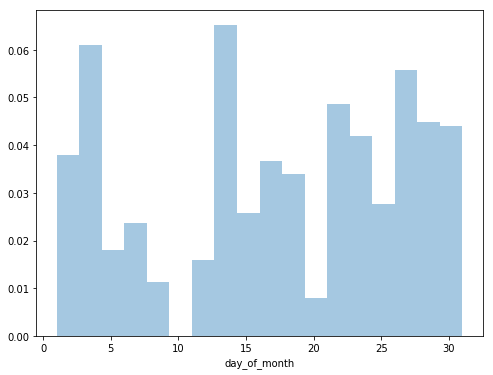

In [217]:
plt.figure(figsize= (8,6))
sns.distplot(df.day_of_month, kde = False, norm_hist = True)

**Day_of_week**

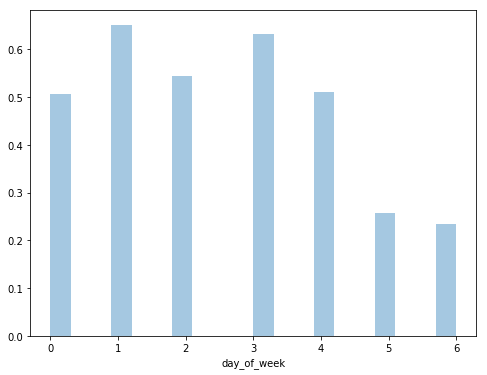

In [218]:
plt.figure(figsize= (8,6))
sns.distplot(df.day_of_week, kde = False, norm_hist = True)

**Day of the year**

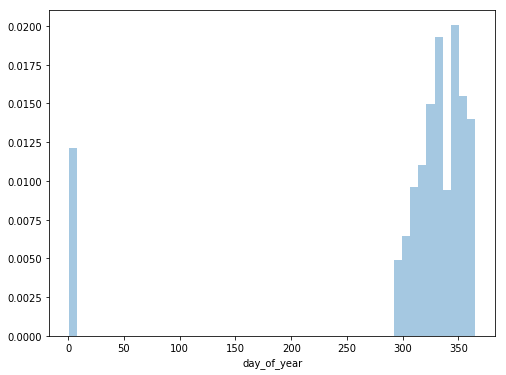

In [219]:
plt.figure(figsize= (8,6))
sns.distplot(df.day_of_year, kde = False, norm_hist = True)

**Length of the tweet**

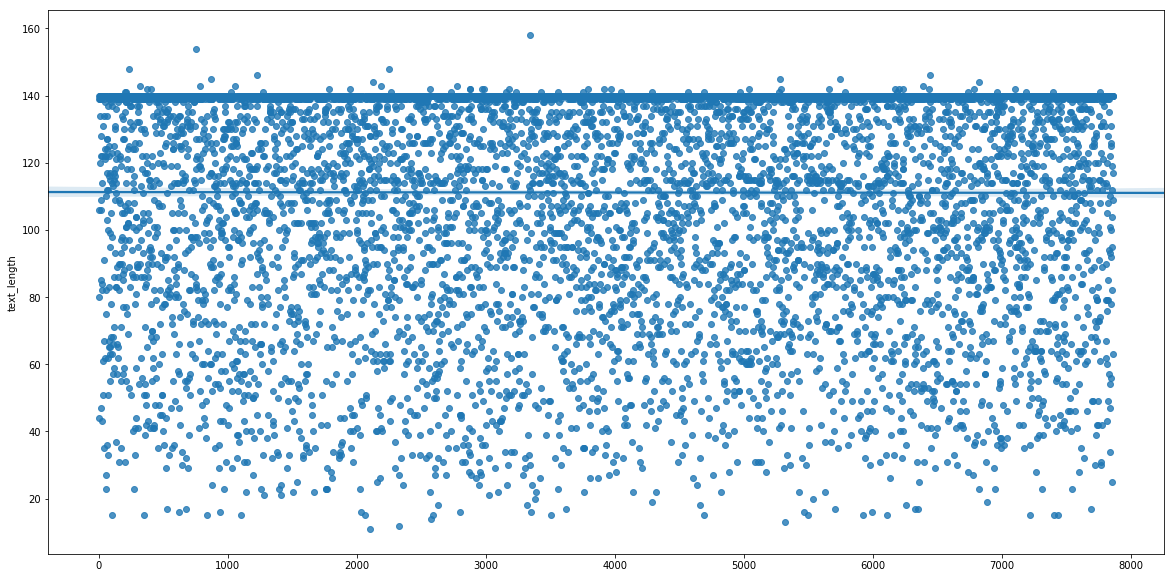

In [220]:
plt.figure(figsize = (20,10))
ax = sns.regplot(np.arange(len(df)), df.text_length)

We can obserbe that nothing useful can be extracted here. Let's try to plot some boxplots depending on the airline sentiment, to see if these variables can be significant for our models:

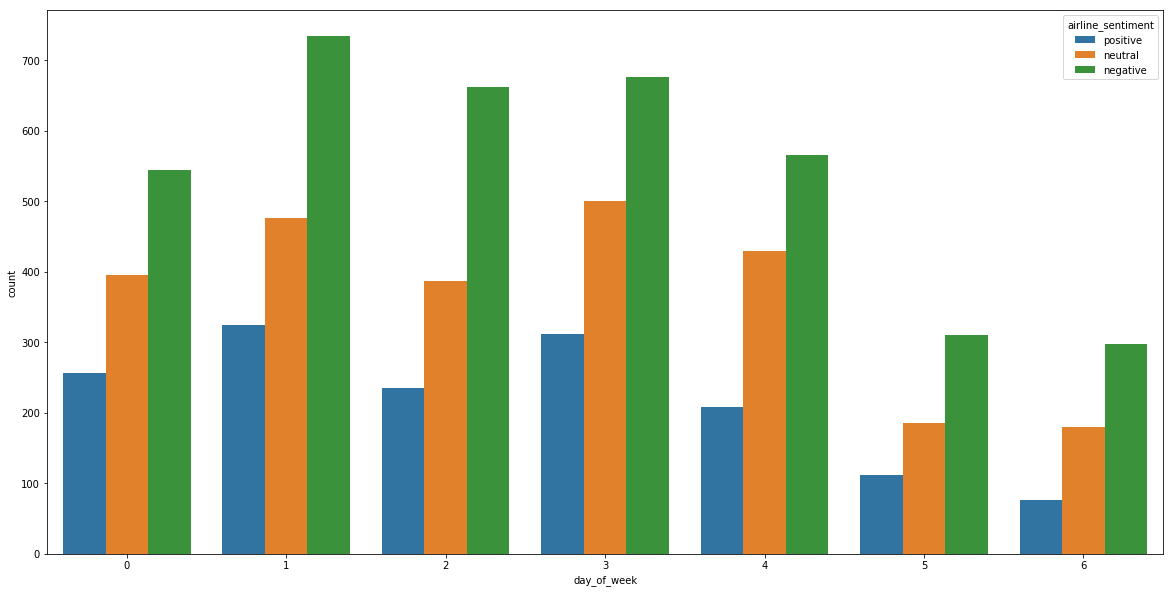

In [221]:
# Day of the week
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_week", hue="airline_sentiment", data = df)
plt.show()

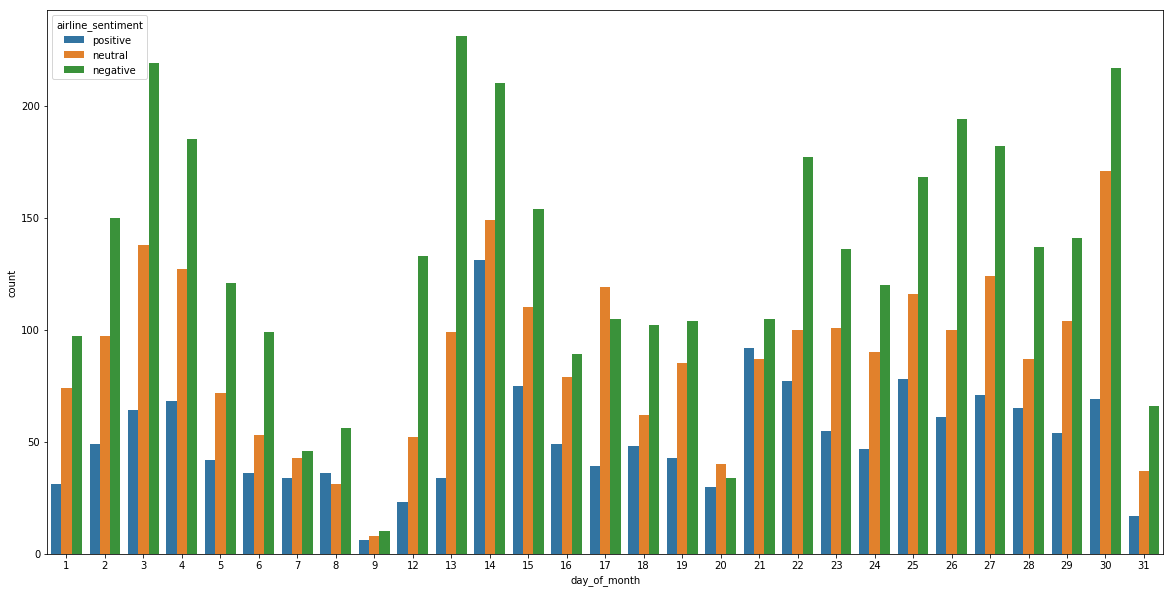

In [222]:
# Day of the month
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_month",hue="airline_sentiment", data = df)
plt.show()

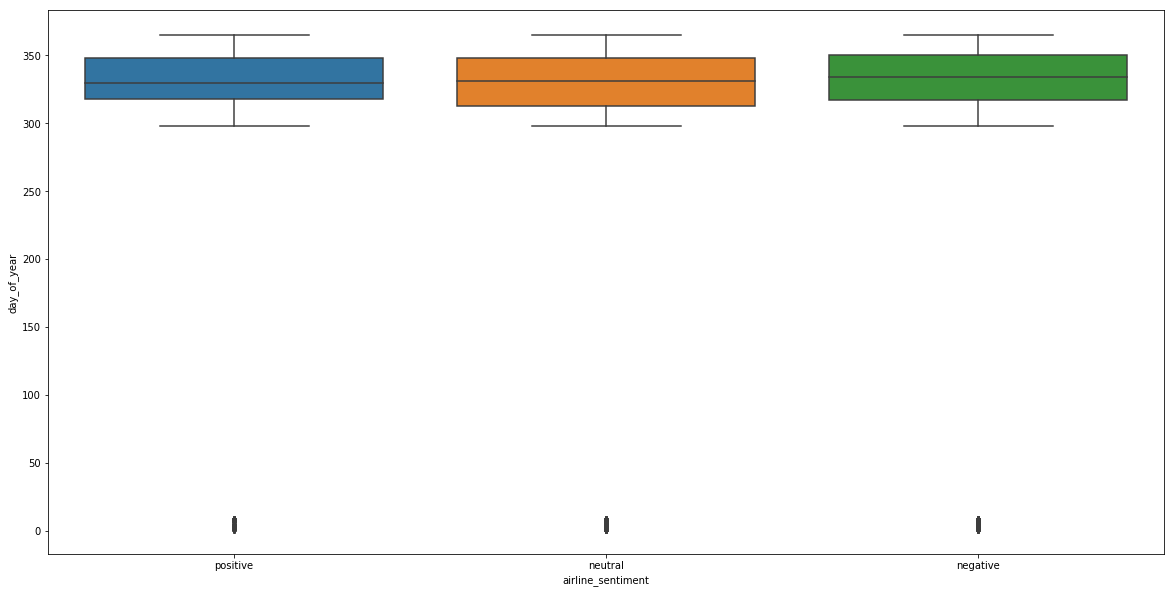

In [223]:
# Day of the year
plt.figure(figsize = (20,10))
ax = sns.boxplot(x = "airline_sentiment",y="day_of_year", data = df, orient = 'v')
plt.show()

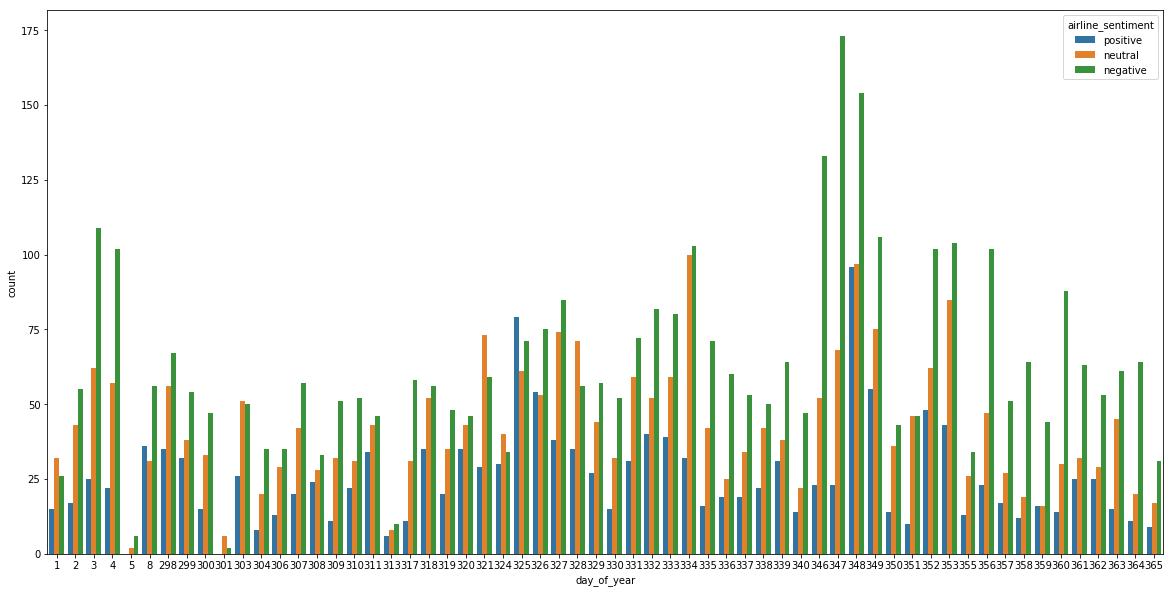

In [224]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_year",hue="airline_sentiment", data = df)
plt.show()

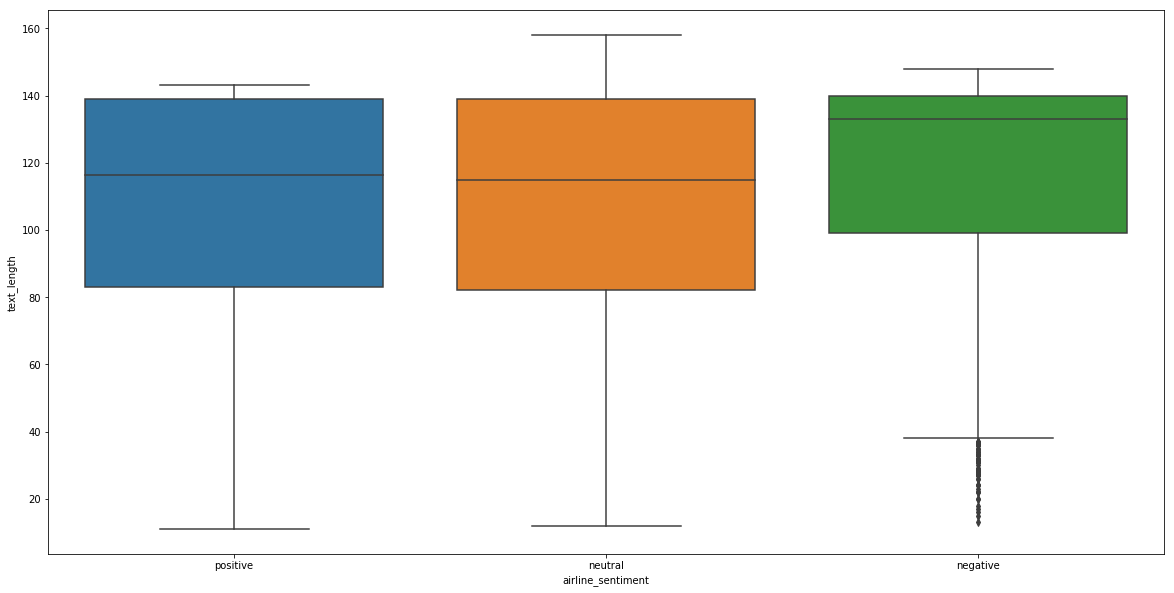

In [225]:
# Length of the tweet
plt.figure(figsize = (20,10))
ax = sns.boxplot(x = "airline_sentiment",y="text_length", data = df, orient = 'v')
plt.show()

## Machine Learning Model: Training and Predicting data

The **input (training) data** will now be pre-processed by using the function **obtain_data_representation** defined above. We will use the **TF-IDF** algorithm in order to transform the *text of the tweet* text column into a vector of numeric features. We will also include in the features the **emojis** that can be found in the text. Other features will be ignored for the moment, as we cannot observe a significant diffrerence between the different values of the objective variables for the numerical features selected. 

The columns of emojis and feature vector of text features extracted will be combined in order to generate a **sparse matrix**, containing as many rows as the number of records (tweets) provided, and a maximum of 250 + different emojis found columns.

This data will be stored under a dictionary. We actually have 2 dictionarys:
1. **dataset**: Contains the pre-process data without including the emoji part.
2. **dataset_em**: Contains the  pre-process data, including another numeric feature vector for the emojis found in the text.

In [226]:
em = re.compile(r'(\xf0\S*)')
rep = re.compile("[\uD800-\uDFFF]", re.UNICODE)
def prep_func(s1):
    s = s1.encode('utf-8')
    aux = []
    emojis = em.findall(s)
    for elem in emojis:
        elem = rep.sub('', elem)
        while len(elem) > 4:
            aux.append(elem[0:4])
            elem = elem[4:]
        aux.append(elem)
    return ','.join(aux)
df['emojis'] = df.apply(lambda x: prep_func(x.text), axis = 1)

In [227]:
dataset = obtain_data_representation(df, counter = 'TFIDF')
dataset_em = obtain_data_representation(df, counter = 'TFIDF', emojis = True)

In [228]:
print 'Full pre-processed training data results size is: \n', dataset['train']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Full pre-processed training data with emojis size is: \n', dataset_em['train']['x'].shape, '\n'

print '---------------------------------------- \n'
print '---------------------------------------- \n'

print 'Full pre-processed testing data results size is: \n', dataset['test']['x'].shape, '\n'
print '---------------------------------------- \n'
print 'Partial pre-processed testing data results size is: \n', dataset_em['test']['x'].shape, '\n'

Full pre-processed training data results size is: 
(5900, 141) 

---------------------------------------- 

Full pre-processed training data with emojis size is: 
(5900, 378) 

---------------------------------------- 

---------------------------------------- 

Full pre-processed testing data results size is: 
(1967, 141) 

---------------------------------------- 

Partial pre-processed testing data results size is: 
(1967, 378) 



##### Machine Learning. We'll try a Bernouilli and a Linear Regression Model

First, let's try a standard **Bernouilli NB** model:

In [14]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(main_dataset['train']['x'], main_dataset['train']['y'])
clf2 = BernoulliNB()
clf2.fit(aux_dataset['train']['x'], aux_dataset['train']['y'])
clf_parsed = BernoulliNB()
clf_parsed.fit(dataset_wp['train']['x'], dataset_wp['train']['y'])

pred1 = clf.predict(main_dataset['test']['x'])
pred2 = clf2.predict(aux_dataset['test']['x'])
pred_parse = clf_parsed.predict(dataset_wp['test']['x'])
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_dataset['test']['y'], pred1))
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_dataset['test']['y'], pred2)), '\n'
print '---------------------------------------------- \n'
print 'The score achieved by the model trained using the parsed text from the tweet is: %2.6f' % (accuracy_score(dataset_wp['test']['y'], pred_parse)), '\n'


The score achieved by the model trained with the full training data is: 0.722678
---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.777351 

---------------------------------------------- 

The score achieved by the model trained using the parsed text from the tweet is: 0.690801 



Confusion Matrix for the first Model 

[[1237  215  106]
 [ 130  184   68]
 [  49   41  166]]


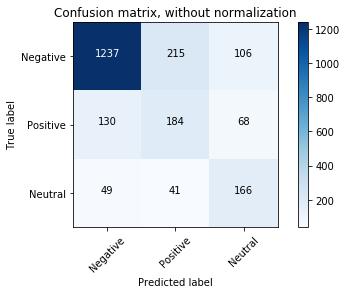

Confusion Matrix for the second model, without outliers 

[[995 119  69]
 [ 81  91  30]
 [ 34  15 129]]


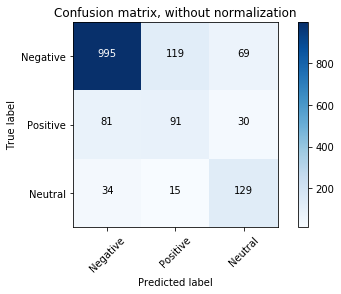

In [15]:
print 'Confusion Matrix for the first Model \n'
cnf_matrix1 = confusion_matrix(pred1, main_dataset['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix2 = confusion_matrix(pred2, aux_dataset['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


Confusion Matrix for the third model, parsing the text of the tweet: 

[[1120  183  118]
 [ 224  228   64]
 [  50   40  169]]


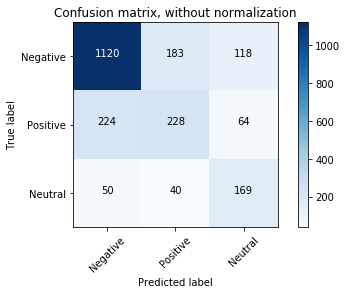

In [16]:
print 'Confusion Matrix for the third model, parsing the text of the tweet: \n'

cnf_matrix_wp = confusion_matrix(pred_parse, dataset_wp['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_wp, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


## Sentiment Analyisis

Let's try now a bit of **sentiment analysis**. We can get a lot of useful information about the sentiment of a tweet by analyzing the emojis that can be found in them. Let's try to create a model with the ability to capture emojis. We will define 2 functions in order to prepocess data:
1. **Function1 - Capture Emojis**: A function to capture the emojis in the text, that will remove from the text everthing that isn't an emoji.
2. **Function2 - Capture userwriten emojis**. We will try to capture with these function emojis like: ":)", ":("...

In [125]:
em = re.compile(r'(\xf0\S*)')
rep = re.compile("[\uD800-\uDFFF]", re.UNICODE)
def prep_func(s):
    aux = []
    emojis = em.findall(s)
    for elem in emojis:
        elem = rep.sub('', elem)
        while len(elem) > 4:
            aux.append(elem[0:4])
            elem = elem[4:]
        aux.append(elem)
    return ','.join(aux)
df['emojis'] = df.apply(lambda x: prep_func(x.text), axis = 1)

In [128]:
df.iloc[4].text

u'@SrtaFarrellDM @KLM @Iberia Eso de avianca es verdad a mi mama le paso dos veces terrible esa aerol\xednea \U0001f624'

In [27]:
dataset_em['train']['x'].toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

The score achieved by the model trained with the full training data including emojis is: 0.660747
Confusion Matrix for the fourth model, including emojis in the text of the tweet: 

[[895  74  27]
 [347 321  78]
 [143  76 235]]


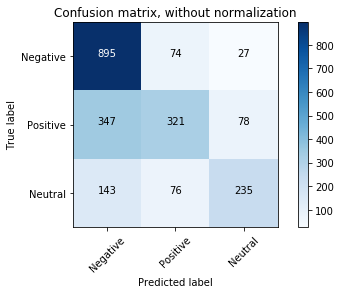

In [19]:
clf_em = BernoulliNB()
clf_em.fit(dataset_em['train']['x'], dataset_em['train']['y'])

pred_em = clf_em.predict(dataset_em['test']['x'])
print 'The score achieved by the model trained with the full training data including emojis is: %2.6f' % (accuracy_score(dataset_em['test']['y'], pred_em))

print 'Confusion Matrix for the fourth model, including emojis in the text of the tweet: \n'

cnf_matrix_em = confusion_matrix(pred_em, dataset_em['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_em, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


In [29]:
# Para el DictVectorizer
#[Counter(s.split()) for s in samples]

In [33]:
y_bin

[negative, positive, negative, negative, negative, ..., positive, neutral, negative, negative, negative]
Length: 6588
Categories (3, object): [negative, neutral, positive]

In [29]:
results = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    })

In [30]:
# Haremos 20 iteraciones para todos los modelos con particiones diferentes de los datos.
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

gaussian = GaussianNB()
logreg = LogisticRegression()
svc = SVC()
linear_svc = LinearSVC()
perceptron = Perceptron()
decisiontree = DecisionTreeClassifier(criterion = 'entropy')
randomforest = RandomForestClassifier(criterion = 'entropy')
knn = KNeighborsClassifier()
sgd = SGDClassifier()
gbk = GradientBoostingClassifier()

x_train = dataset_em['train']['x'].toarray()
y_train = dataset_em['train']['y']

x_val = dataset_em['test']['x'].toarray()
y_val = dataset_em['test']['y']


p_l = 'negative'
for i in range(1,20):
    dataset_em = obtain_data_representation_emojis(df)
    
    x_train = dataset_em['train']['x'].toarray()
    y_train = dataset_em['train']['y']

    x_val = dataset_em['test']['x'].toarray()
    y_val = dataset_em['test']['y']
    '''if (i // 10 > 0):
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.25)

    else:
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.20)'''

# acc_svmc, acc_knn, acc_lreg, acc_randomforest, acc_gau, acc_perceptron,acc_lsvmc, acc_decisiontree,acc_sgd, acc_gbk
    # Calculamos todas las predicciones y todas las precisiones:
    print('Calculating iteration ' + str(i))
    
    # Gaussian Naive Bayes:
    gaussian.fit(x_train, y_train)
    y_pred = gaussian.predict(x_val)
    acc_gau = accuracy_score(y_pred, y_val)
    '''f1_gau = f1_score(y_pred, y_val)
    rec_gau = recall_score(y_pred, y_val)
    prec_gau = precision_score(y_pred, y_val)'''
    
    # Logistic regression:
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_val)
    acc_lreg = accuracy_score(y_pred, y_val)
    '''f1_lreg = f1_score(y_pred, y_val)
    rec_lreg = recall_score(y_pred, y_val)
    prec_lreg = precision_score(y_pred, y_val)'''
    
    # SVMC y LSVMC:
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_val)
    acc_svmc = accuracy_score(y_pred, y_val)
    '''f1_svmc = f1_score(y_pred, y_val)
    rec_svmc = recall_score(y_pred, y_val)
    prec_svmc = precision_score(y_pred, y_val)'''
    
    linear_svc.fit(x_train, y_train)
    y_pred = linear_svc.predict(x_val)     
    acc_lsvmc = accuracy_score(y_pred, y_val)
    '''f1_lsvmc = f1_score(y_pred, y_val)
    rec_lsvmc = recall_score(y_pred, y_val)
    prec_lsvmc = precision_score(y_pred, y_val)'''
    
    # Perceptron:
    perceptron.fit(x_train, y_train)
    y_pred = perceptron.predict(x_val)
    acc_perceptron = accuracy_score(y_pred, y_val)
    '''f1_perceptron = f1_score(y_pred, y_val)
    rec_perceptron = recall_score(y_pred, y_val)
    prec_perceptron = precision_score(y_pred, y_val)'''
    
    # Decision tree:
    decisiontree.fit(x_train, y_train)
    y_pred = decisiontree.predict(x_val)
    acc_dtree = accuracy_score(y_pred, y_val)
    '''f1_dtree = f1_score(y_pred, y_val)
    rec_dtree = recall_score(y_pred, y_val)
    prec_dtree = precision_score(y_pred, y_val)'''
    
    # Random Forest:
    randomforest.fit(x_train, y_train)
    y_pred = randomforest.predict(x_val)
    acc_rf = accuracy_score(y_pred, y_val)
    '''f1_rf = f1_score(y_pred, y_val)
    rec_rf = recall_score(y_pred, y_val)
    prec_rf = precision_score(y_pred, y_val)'''
    
    # KNN:
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    acc_knn = accuracy_score(y_pred, y_val)
    '''f1_knn = f1_score(y_pred, y_val)
    rec_knn = recall_score(y_pred, y_val)
    prec_knn = precision_score(y_pred, y_val)'''
    
    # Gradient Descent:
    sgd.fit(x_train, y_train)
    y_pred = sgd.predict(x_val)    
    acc_sgd = accuracy_score(y_pred, y_val)
    '''f1_sgd = f1_score(y_pred, y_val)
    rec_sgd = recall_score(y_pred, y_val)
    prec_sgd = precision_score(y_pred, y_val)'''
    
    # Gradient boosting:
    gbk.fit(x_train, y_train)
    y_pred = gbk.predict(x_val)
    acc_gbk = accuracy_score(y_pred, y_val)
    '''f1_gbk = f1_score(y_pred, y_val)
    rec_gbk = recall_score(y_pred, y_val)
    prec_gbk = precision_score(y_pred, y_val)'''
    
    # Lo metemos todo en la DF de resultados:
    results['Accuracy_'+str(i)] = [acc_svmc, acc_knn, acc_lreg, 
              acc_rf, acc_gau, acc_perceptron,acc_lsvmc, acc_dtree,
              acc_sgd, acc_gbk]
    '''results['F1_score_'+str(i)] = [f1_svmc, f1_knn, f1_lreg, 
              f1_rf, f1_gau, f1_perceptron,f1_lsvmc, f1_dtree,
              f1_sgd, f1_gbk]
    results['Recall_'+str(i)] = [rec_svmc, rec_knn, rec_lreg, 
              rec_rf, rec_gau, rec_perceptron,rec_lsvmc, rec_dtree,
              rec_sgd, rec_gbk]
    results['Precision_'+str(i)] = [prec_svmc, prec_knn, prec_lreg, 
              prec_rf, prec_gau, prec_perceptron,prec_lsvmc, prec_dtree,
              prec_sgd, prec_gbk]'''

Calculating iteration 1
Calculating iteration 2
Calculating iteration 3
Calculating iteration 4
Calculating iteration 5
Calculating iteration 6
Calculating iteration 7
Calculating iteration 8
Calculating iteration 9
Calculating iteration 10
Calculating iteration 11
Calculating iteration 12
Calculating iteration 13
Calculating iteration 14
Calculating iteration 15
Calculating iteration 16
Calculating iteration 17
Calculating iteration 18
Calculating iteration 19


In [31]:
results.index = results.Model
accuracy = results[['Accuracy_' + str(i) for i in range(1,20)]]
accuracy.index = results.Model
accuracy['mean_accuracy'] = accuracy.mean(axis = 1)
accuracy

,Accuracy_1,Accuracy_2,Accuracy_3,Accuracy_4,Accuracy_5,Accuracy_6,Accuracy_7,Accuracy_8,Accuracy_9,Accuracy_10,Accuracy_11,Accuracy_12,Accuracy_13,Accuracy_14,Accuracy_15,Accuracy_16,Accuracy_17,Accuracy_18,Accuracy_19,mean_accuracy
Model,,,,,,,,,,,,,,,,,,,,
Support Vector Machines,0.646630,0.622951,0.652095,0.633424,0.647996,0.636157,0.641621,0.648907,0.638889,0.649362,0.644809,0.644809,0.645719,0.636157,0.664390,0.648907,0.642532,0.646630,0.628415,0.643179
KNN,0.679417,0.697632,0.689891,0.668488,0.679417,0.666211,0.671220,0.683060,0.670310,0.697177,0.685337,0.697177,0.690346,0.661658,0.697632,0.683971,0.688525,0.686248,0.666211,0.682101
Logistic Regression,0.730419,0.719945,0.740893,0.705829,0.714481,0.712204,0.709927,0.731330,0.696721,0.722678,0.711749,0.720401,0.721767,0.724499,0.697632,0.720856,0.708106,0.723133,0.699909,0.716446
Random Forest,0.667577,0.644353,0.698998,0.664845,0.663479,0.646175,0.601548,0.684882,0.639344,0.656193,0.647541,0.663024,0.643443,0.639344,0.592896,0.653005,0.662568,0.684426,0.659836,0.653341
Naive Bayes,0.698087,0.679417,0.680328,0.676685,0.689891,0.677596,0.674863,0.696266,0.683515,0.686703,0.620674,0.703552,0.628415,0.693534,0.686703,0.676685,0.530965,0.679417,0.564663,0.664629
Perceptron,0.675319,0.682149,0.694900,0.676685,0.621129,0.640255,0.671220,0.663024,0.678051,0.692623,0.563752,0.622951,0.702641,0.697177,0.601548,0.671220,0.703097,0.698998,0.666667,0.664390
Linear SVC,0.729508,0.728597,0.735428,0.711293,0.726321,0.724499,0.715392,0.742259,0.714936,0.725410,0.725410,0.736339,0.729964,0.725410,0.724499,0.720856,0.711749,0.742714,0.700820,0.724811
Decision Tree,0.634791,0.567395,0.589709,0.565574,0.636612,0.608379,0.613843,0.578324,0.584699,0.572404,0.615209,0.582423,0.618397,0.615209,0.587432,0.609745,0.615665,0.621129,0.614299,0.601644
Stochastic Gradient Descent,0.716302,0.685792,0.719945,0.698543,0.716302,0.719490,0.706740,0.723133,0.699454,0.723588,0.698998,0.709016,0.704463,0.690346,0.661658,0.699454,0.696266,0.725410,0.692168,0.704582


Boxplots of the accuracy score achieved for each of the models


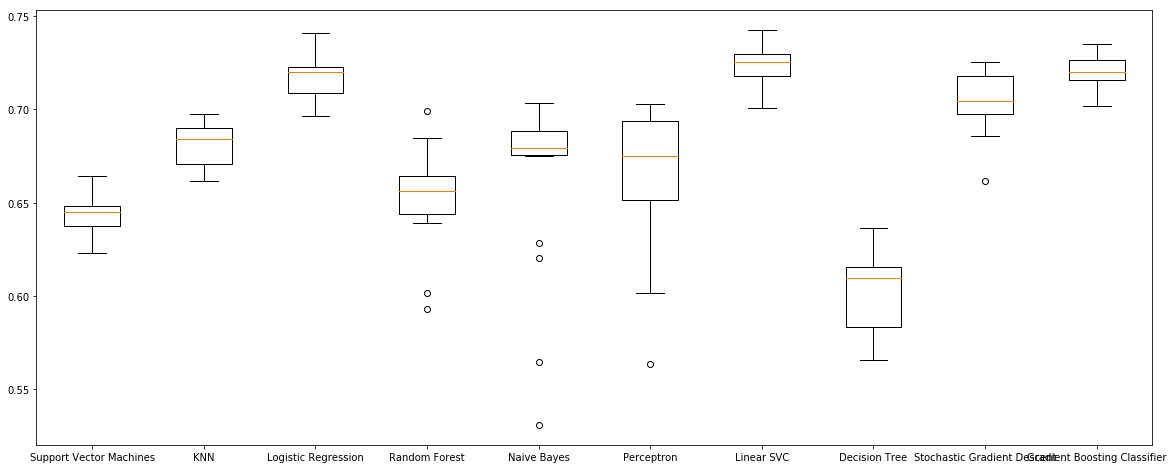

In [32]:
print('Boxplots of the accuracy score achieved for each of the models')

fig, ax = plt.subplots(figsize = (20,8))
plt.boxplot(accuracy[['Accuracy_' + str(i) for i in range(1,20)]])
ax.set_xticklabels(accuracy.index)
plt.show()

In [36]:
results2 = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    })

In [37]:
# Haremos 20 iteraciones para todos los modelos con particiones diferentes de los datos.
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

gaussian = GaussianNB()
logreg = LogisticRegression()
svc = SVC()
linear_svc = LinearSVC()
perceptron = Perceptron()
decisiontree = DecisionTreeClassifier(criterion = 'entropy')
randomforest = RandomForestClassifier(criterion = 'entropy')
knn = KNeighborsClassifier()
sgd = SGDClassifier()
gbk = GradientBoostingClassifier()




p_l = 'negative'
for i in range(1,20):
    main_dataset = obtain_data_representation(df)
    x_train = main_dataset['train']['x'].toarray()
    y_train = main_dataset['train']['y']

    x_val = main_dataset['test']['x'].toarray()
    y_val = main_dataset['test']['y']
    # acc_svmc, acc_knn, acc_lreg, acc_randomforest, acc_gau, acc_perceptron,acc_lsvmc, acc_decisiontree,acc_sgd, acc_gbk
    # Calculamos todas las predicciones y todas las precisiones:
    print('Calculating iteration ' + str(i))
    
    # Gaussian Naive Bayes:
    gaussian.fit(x_train, y_train)
    y_pred = gaussian.predict(x_val)
    acc_gau = accuracy_score(y_pred, y_val)
    '''f1_gau = f1_score(y_pred, y_val)
    rec_gau = recall_score(y_pred, y_val)
    prec_gau = precision_score(y_pred, y_val)'''
    
    # Logistic regression:
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_val)
    acc_lreg = accuracy_score(y_pred, y_val)
    '''f1_lreg = f1_score(y_pred, y_val)
    rec_lreg = recall_score(y_pred, y_val)
    prec_lreg = precision_score(y_pred, y_val)'''
    
    # SVMC y LSVMC:
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_val)
    acc_svmc = accuracy_score(y_pred, y_val)
    '''f1_svmc = f1_score(y_pred, y_val)
    rec_svmc = recall_score(y_pred, y_val)
    prec_svmc = precision_score(y_pred, y_val)'''
    
    linear_svc.fit(x_train, y_train)
    y_pred = linear_svc.predict(x_val)     
    acc_lsvmc = accuracy_score(y_pred, y_val)
    '''f1_lsvmc = f1_score(y_pred, y_val)
    rec_lsvmc = recall_score(y_pred, y_val)
    prec_lsvmc = precision_score(y_pred, y_val)'''
    
    # Perceptron:
    perceptron.fit(x_train, y_train)
    y_pred = perceptron.predict(x_val)
    acc_perceptron = accuracy_score(y_pred, y_val)
    '''f1_perceptron = f1_score(y_pred, y_val)
    rec_perceptron = recall_score(y_pred, y_val)
    prec_perceptron = precision_score(y_pred, y_val)'''
    
    # Decision tree:
    decisiontree.fit(x_train, y_train)
    y_pred = decisiontree.predict(x_val)
    acc_dtree = accuracy_score(y_pred, y_val)
    '''f1_dtree = f1_score(y_pred, y_val)
    rec_dtree = recall_score(y_pred, y_val)
    prec_dtree = precision_score(y_pred, y_val)'''
    
    # Random Forest:
    randomforest.fit(x_train, y_train)
    y_pred = randomforest.predict(x_val)
    acc_rf = accuracy_score(y_pred, y_val)
    '''f1_rf = f1_score(y_pred, y_val)
    rec_rf = recall_score(y_pred, y_val)
    prec_rf = precision_score(y_pred, y_val)'''
    
    # KNN:
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    acc_knn = accuracy_score(y_pred, y_val)
    '''f1_knn = f1_score(y_pred, y_val)
    rec_knn = recall_score(y_pred, y_val)
    prec_knn = precision_score(y_pred, y_val)'''
    
    # Gradient Descent:
    sgd.fit(x_train, y_train)
    y_pred = sgd.predict(x_val)    
    acc_sgd = accuracy_score(y_pred, y_val)
    '''f1_sgd = f1_score(y_pred, y_val)
    rec_sgd = recall_score(y_pred, y_val)
    prec_sgd = precision_score(y_pred, y_val)'''
    
    # Gradient boosting:
    gbk.fit(x_train, y_train)
    y_pred = gbk.predict(x_val)
    acc_gbk = accuracy_score(y_pred, y_val)
    '''f1_gbk = f1_score(y_pred, y_val)
    rec_gbk = recall_score(y_pred, y_val)
    prec_gbk = precision_score(y_pred, y_val)'''
    
    # Lo metemos todo en la DF de resultados:
    results2['Accuracy_'+str(i)] = [acc_svmc, acc_knn, acc_lreg, 
              acc_rf, acc_gau, acc_perceptron,acc_lsvmc, acc_dtree,
              acc_sgd, acc_gbk]
    '''results['F1_score_'+str(i)] = [f1_svmc, f1_knn, f1_lreg, 
              f1_rf, f1_gau, f1_perceptron,f1_lsvmc, f1_dtree,
              f1_sgd, f1_gbk]
    results['Recall_'+str(i)] = [rec_svmc, rec_knn, rec_lreg, 
              rec_rf, rec_gau, rec_perceptron,rec_lsvmc, rec_dtree,
              rec_sgd, rec_gbk]
    results['Precision_'+str(i)] = [prec_svmc, prec_knn, prec_lreg, 
              prec_rf, prec_gau, prec_perceptron,prec_lsvmc, prec_dtree,
              prec_sgd, prec_gbk]'''

Calculating iteration 1
Calculating iteration 2
Calculating iteration 3
Calculating iteration 4
Calculating iteration 5
Calculating iteration 6
Calculating iteration 7
Calculating iteration 8
Calculating iteration 9
Calculating iteration 10
Calculating iteration 11
Calculating iteration 12
Calculating iteration 13
Calculating iteration 14
Calculating iteration 15
Calculating iteration 16
Calculating iteration 17
Calculating iteration 18
Calculating iteration 19


In [38]:
results2.index = results.Model
accuracy2 = results2[['Accuracy_' + str(i) for i in range(1,20)]]
accuracy2.index = results2.Model
accuracy2['mean_accuracy'] = accuracy2.mean(axis = 1)
accuracy2

,Accuracy_1,Accuracy_2,Accuracy_3,Accuracy_4,Accuracy_5,Accuracy_6,Accuracy_7,Accuracy_8,Accuracy_9,Accuracy_10,Accuracy_11,Accuracy_12,Accuracy_13,Accuracy_14,Accuracy_15,Accuracy_16,Accuracy_17,Accuracy_18,Accuracy_19,mean_accuracy
Model,,,,,,,,,,,,,,,,,,,,
Support Vector Machines,0.669399,0.672131,0.684426,0.661202,0.678506,0.693534,0.672587,0.670310,0.671676,0.661658,0.663479,0.675319,0.669854,0.677596,0.652095,0.675774,0.654827,0.685792,0.664845,0.671316
KNN,0.671220,0.661658,0.660747,0.672131,0.681239,0.718124,0.693534,0.701275,0.695811,0.669399,0.668488,0.697177,0.673953,0.668033,0.687158,0.672131,0.674408,0.703552,0.690801,0.682149
Logistic Regression,0.725410,0.715847,0.729053,0.709472,0.751821,0.745902,0.734973,0.728597,0.732240,0.720401,0.721767,0.731785,0.720401,0.723588,0.720856,0.724954,0.714026,0.733151,0.718124,0.726440
Random Forest,0.707195,0.688980,0.712659,0.696266,0.716302,0.721767,0.716302,0.714026,0.708561,0.692623,0.702186,0.709472,0.705829,0.696721,0.706740,0.714481,0.700364,0.722222,0.711749,0.707602
Naive Bayes,0.498634,0.496812,0.479053,0.484517,0.501821,0.510929,0.478142,0.505464,0.487250,0.497723,0.508197,0.499545,0.489071,0.478142,0.505464,0.500000,0.497723,0.508197,0.492714,0.495758
Perceptron,0.679417,0.672587,0.626138,0.519581,0.703552,0.651639,0.643443,0.603825,0.678506,0.513206,0.672131,0.648452,0.692168,0.675774,0.552368,0.695811,0.609290,0.651639,0.674408,0.640207
Linear SVC,0.726776,0.714481,0.724954,0.711749,0.749089,0.749545,0.736339,0.729053,0.732240,0.719490,0.715847,0.733607,0.718579,0.723133,0.723133,0.725865,0.717668,0.734062,0.717668,0.726488
Decision Tree,0.675319,0.659836,0.675774,0.673042,0.678051,0.689891,0.673042,0.668488,0.683515,0.660747,0.670765,0.679872,0.662568,0.668944,0.676230,0.693989,0.667122,0.674408,0.659381,0.673210
Stochastic Gradient Descent,0.714936,0.693989,0.726776,0.708106,0.724044,0.740893,0.721767,0.717668,0.726776,0.715847,0.712659,0.711293,0.710838,0.701275,0.692168,0.719945,0.705829,0.711293,0.715847,0.714313


Boxplots of the accuracy score achieved for each of the models


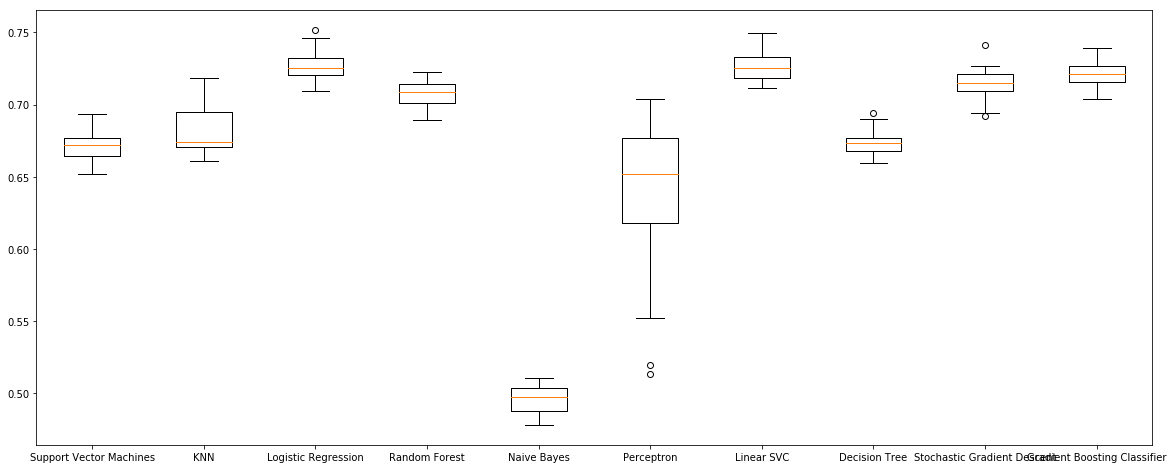

In [39]:
print('Boxplots of the accuracy score achieved for each of the models')

fig, ax = plt.subplots(figsize = (20,8))
plt.boxplot(accuracy2[['Accuracy_' + str(i) for i in range(1,20)]])
ax.set_xticklabels(accuracy2.index)
plt.show()

## Adding numerical features to predict with other classifiers.

Now, we'll create two separate models to see if our predictions are improved in some way. The first model will predict values based on the text of the tweet and the second one, on the airline, the retweet count and the date. But as we cannot feed the pure dates into our ML model, we'll do some feature engineering first:
- Create some useful such us day_of_week, day_of_month, day_of_year
- We have seen that something weird happenned on the 23rd of February of 2015 there was a great amount of people that tweeted with a negative sentiment, so we'll create a bool variable that will indicate wether the tweet has been issued on this day.

Al the things mentioned above will be done in the function: **dealwith_dates**

In [30]:
# df = dealwith_dates(df)
# dfaux = dealwith_dates(dfaux)
# main_df = obtain_data_representation2(df)
# aux_df = obtain_data_representation2(dfaux)

Now, let's try the linear **regression model**:

In [31]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
main_df['num']['train']['x'] = scaler1.fit_transform(main_df['num']['train']['x'])
main_df['num']['test']['x'] = scaler1.transform(main_df['num']['test']['x'])

aux_df['num']['train']['x'] = scaler2.fit_transform(aux_df['num']['train']['x'])
aux_df['num']['test']['x'] = scaler2.transform(aux_df['num']['test']['x'])

clf_num1 = RandomForestClassifier()
clf_num1.fit(main_df['num']['train']['x'], main_df['num']['train']['y'])
clf_num2 = RandomForestClassifier()
clf_num2.fit(aux_df['num']['train']['x'], aux_df['num']['train']['y'])

pred_num1 = clf_num1.predict(main_df['num']['test']['x'])
pred_num2 = clf_num2.predict(aux_df['num']['test']['x'])
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_df['num']['test']['y'], pred_num1))
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_df['num']['test']['y'], pred_num2)), '\n'


print 'Confusion Matrix for the first Model \n'
cnf_matrix_num1 = confusion_matrix(pred_num1, main_df['num']['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_num1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()

print 'Confusion Matrix for the second model, without outliers \n'

cnf_matrix_num2 = confusion_matrix(pred_num2, aux_df['num']['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix_num2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()'''


"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.preprocessing import MinMaxScaler\nscaler1 = MinMaxScaler()\nscaler2 = MinMaxScaler()\nmain_df['num']['train']['x'] = scaler1.fit_transform(main_df['num']['train']['x'])\nmain_df['num']['test']['x'] = scaler1.transform(main_df['num']['test']['x'])\n\naux_df['num']['train']['x'] = scaler2.fit_transform(aux_df['num']['train']['x'])\naux_df['num']['test']['x'] = scaler2.transform(aux_df['num']['test']['x'])\n\nclf_num1 = RandomForestClassifier()\nclf_num1.fit(main_df['num']['train']['x'], main_df['num']['train']['y'])\nclf_num2 = RandomForestClassifier()\nclf_num2.fit(aux_df['num']['train']['x'], aux_df['num']['train']['y'])\n\npred_num1 = clf_num1.predict(main_df['num']['test']['x'])\npred_num2 = clf_num2.predict(aux_df['num']['test']['x'])\nprint 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_df['num']['test']['y'], pred_num1))\nprint '------------------------------

In [32]:
# main_df['num']['train']['x']

##### XGBOOST

The xgboost model will be used in the first place to create a first prediction. Two models will be created that will use (in the first place) the same parameters, to see whether it is better to train the model with the corrected data, or with the full dataset

In [36]:
import xgboost as xgb
xgb_params = {
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 1
}

ImportError: No module named xgboost

In [34]:
gbm1 = xgb.XGBClassifier()
gbm2 = xgb.XGBClassifier()
# gbm.fit(dataset['train']['x'], dataset['train']['y'],eval_set=[(dataset['train']['x'], dataset['train']['y']), (dataset['test']['x'], dataset['test']['y'])], eval_metric='logloss', verbose=True)

gbm1.fit(main_dataset['train']['x'], main_dataset['train']['y'])
gbm2.fit(aux_dataset['train']['x'], aux_dataset['train']['y'])
gbm3.fit(dataset_em['train']['x'], dataset_em['train']['y'])

pred1 = gbm1.predict(main_dataset['test']['x'])
pred2 = gbm2.predict(aux_dataset['test']['x'])
pred3 = gbm3.predict(dataset_em['test']['x'])

NameError: name 'xgb' is not defined

In [27]:
print 'The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(main_dataset['test']['y'], pred1)), '\n'
print '---------------------------------------------- \n'
print 'The score achieved by the model trained with the filtered training data is: %2.6f' % (accuracy_score(aux_dataset['test']['y'], pred2)), '\n'


The score achieved by the model trained with the full training data is: 0.739071 

---------------------------------------------- 

The score achieved by the model trained with the filtered training data is: 0.808061 



### Tuning the parameters

In [8]:
'''from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV 

xgb_model = XGBClassifier(other_params)

test_params = {
 'max_depth':[4,8,12]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
model.fit(train,target)
print model.best_params_'''

"from xgboost.sklearn import XGBClassifier\nfrom sklearn.grid_search import GridSearchCV \n\nxgb_model = XGBClassifier(other_params)\n\ntest_params = {\n 'max_depth':[4,8,12]\n}\n\nmodel = GridSearchCV(estimator = xgb_model,param_grid = test_params)\nmodel.fit(train,target)\nprint model.best_params_"

## Get output

In [22]:
'''import datetime

def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

    
# Read submission and retrain with whole data
df_submission = pd.read_csv('tweets_submission.csv', index_col='tweet_id')
# We use df_submision as test, otherwise it would split df in train/test
submission_dataset = obtain_data_representation(df, df_submission)

print 'The shape of the testing dataset is: (%i, %i)' % (df_submission.shape), '\n'

print submission_dataset
predictions = clf.predict(submission_dataset['test']['x'])
# Create submission file with obtained y_pred
create_submit_file(df_submission, predictions)'''

'import datetime\n\ndef create_submit_file(df_submission, ypred):\n    date = datetime.datetime.now().strftime("%m_%d_%Y")\n    filename = \'submission_\' + date + \'.csv\'\n    \n    df_submission[\'airline_sentiment\'] = ypred\n    df_submission[[\'airline_sentiment\']].to_csv(filename)\n    \n    print(\'Submission file created: {}\'.format(filename))\n    print(\'Upload it to Kaggle InClass\')\n\n    \n# Read submission and retrain with whole data\ndf_submission = pd.read_csv(\'tweets_submission.csv\', index_col=\'tweet_id\')\n# We use df_submision as test, otherwise it would split df in train/test\nsubmission_dataset = obtain_data_representation(df, df_submission)\n\nprint \'The shape of the testing dataset is: (%i, %i)\' % (df_submission.shape), \'\n\'\n\nprint submission_dataset\npredictions = clf.predict(submission_dataset[\'test\'][\'x\'])\n# Create submission file with obtained y_pred\ncreate_submit_file(df_submission, predictions)'

In [23]:
# df_submission